Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded successfully.


Processing texts: 100%|██████████████████████████████████████████████████████████| 12284/12284 [54:51<00:00,  3.73it/s]


Metrics for class 'Negative':
  Precision: 0.6900
  Recall:    0.7777
  F1-Score:  0.7312
  Support:   3972

Metrics for class 'Neutral':
  Precision: 0.7150
  Recall:    0.7054
  F1-Score:  0.7102
  Support:   5937

Metrics for class 'Positive':
  Precision: 0.7421
  Recall:    0.6093
  F1-Score:  0.6691
  Support:   2375

Confusion Matrix:
[[3089  835   48]
 [1294 4188  455]
 [  94  834 1447]]

Confusion Matrix Explanation:
3089 negatives were correctly classified as Negative (True Negative).
835 negatives were misclassified as Neutral.
48 negatives were misclassified as Positive.
1294 neutrals were misclassified as Negative.
4188 neutrals were correctly classified as Neutral (True Neutral).
455 neutrals were misclassified as Positive.
94 positives were misclassified as Negative.
834 positives were misclassified as Neutral.
1447 positives were correctly classified as Positive (True Positive).


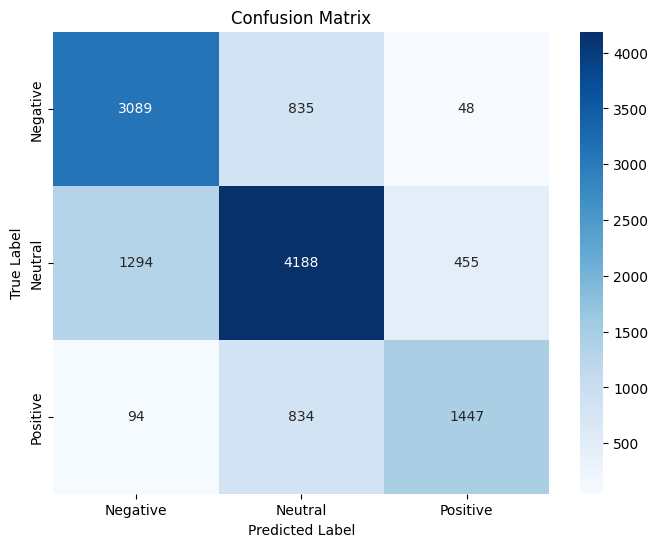

Overall Accuracy: 0.7102
ROC-AUC for class 'Negative': 0.8964
ROC-AUC for class 'Neutral': 0.8007
ROC-AUC for class 'Positive': 0.9133


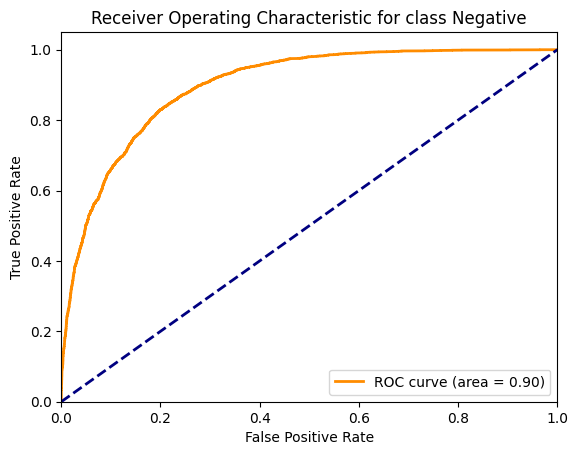

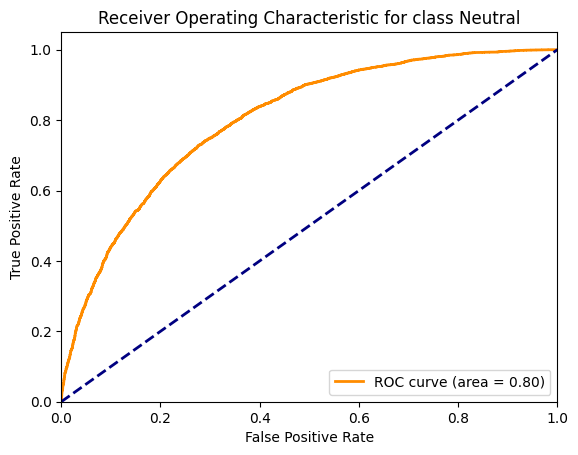

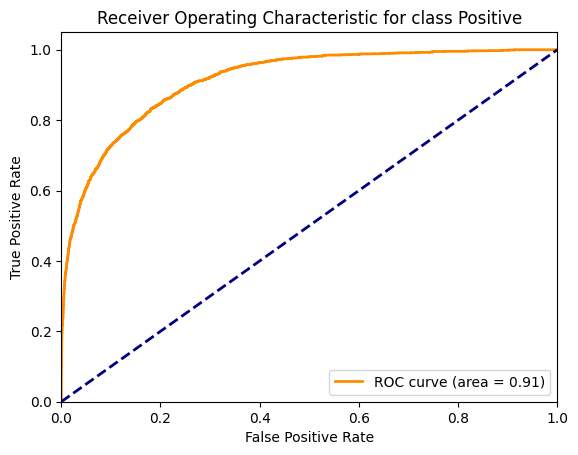

In [4]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from scipy.special import softmax
import numpy as np
from tqdm import tqdm
import torch
import seaborn as sns

# Load the test data
with open('../sentiment-data/cleaned_test_text.txt', 'r', encoding='utf-8') as file:
    test_texts = file.readlines()

with open('../sentiment-data/test_labels.txt', 'r', encoding='utf-8') as file:
    true_labels = [int(label.strip()) for label in file.readlines()]

# Load the model, tokenizer, and configuration
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading the model: {e}")
    exit()

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Initialize lists for predictions and scores
pred_labels = []
pred_scores = []

# Process each text and get predictions with progress bar
for text in tqdm(test_texts, desc="Processing texts"):
    text = preprocess(text.strip())  # Remove leading/trailing spaces and preprocess
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():  # Disable gradient calculation for inference
        output = model(**encoded_input)
    scores = output[0][0].cpu().numpy()
    scores = softmax(scores)
    
    pred_labels.append(np.argmax(scores))  # Get the predicted label
    pred_scores.append(scores)  # Store the softmax scores

# Convert to arrays
pred_labels = np.array(pred_labels)
true_labels = np.array(true_labels)
pred_scores = np.array(pred_scores)

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Calculate precision, recall, F1-score, and support for each class
precision, recall, f1, support = precision_recall_fscore_support(true_labels, pred_labels, average=None, labels=[0, 1, 2])

# Print metrics for each class
class_names = ['Negative', 'Neutral', 'Positive']
for i, class_name in enumerate(class_names):
    print(f"Metrics for class '{class_name}':")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-Score:  {f1[i]:.4f}")
    print(f"  Support:   {support[i]}")
    print()

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Explanation of the confusion matrix
print("\nConfusion Matrix Explanation:")

# Negative class explanation
print(f"{conf_matrix[0, 0]} negatives were correctly classified as Negative (True Negative).")
print(f"{conf_matrix[0, 1]} negatives were misclassified as Neutral.")
print(f"{conf_matrix[0, 2]} negatives were misclassified as Positive.")

# Neutral class explanation
print(f"{conf_matrix[1, 0]} neutrals were misclassified as Negative.")
print(f"{conf_matrix[1, 1]} neutrals were correctly classified as Neutral (True Neutral).")
print(f"{conf_matrix[1, 2]} neutrals were misclassified as Positive.")

# Positive class explanation
print(f"{conf_matrix[2, 0]} positives were misclassified as Negative.")
print(f"{conf_matrix[2, 1]} positives were misclassified as Neutral.")
print(f"{conf_matrix[2, 2]} positives were correctly classified as Positive (True Positive).")

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show(block=False)

# Calculate ROC-AUC (For multiclass, use One-vs-Rest approach)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):  # Assuming three classes
    fpr[i], tpr[i], _ = roc_curve(true_labels, pred_scores[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print overall accuracy and ROC-AUC for each class
print(f"Overall Accuracy: {accuracy:.4f}")
for i in range(3):
    print(f"ROC-AUC for class '{class_names[i]}': {roc_auc[i]:.4f}")

# Plot ROC curve for each class
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for class {class_names[i]}')
    plt.legend(loc="lower right")
    plt.show(block=False)  # Non-blocking show
